This is a **CNN** (Convolution Neural Network) model that developed for detect **COVID-19** using chest XRAY images. For the deep learning model **ResNet50** is used and the model could able to get an accuracy of **95.58%**. This model also possible to detect Pneumonia.



#Import libraries



In [ ]:
import tensorflow as tf
import os
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import pandas as pd # read and write csv
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

#Load data

##Load data from google drive

In [ ]:
from google.colab import drive #mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TrianImage="/content/drive/MyDrive/Projects/Data Management Project/Data set/train" #training images path
TestImage="/content/drive/MyDrive/Projects/Data Management Project/Data set/test" #testing images path
Normalimages = os.listdir(TrianImage + "/NORMAL")
Pneumonaimages = os.listdir(TrianImage + "/PNEUMONIA")
COVID19images = os.listdir(TrianImage + "/COVID19")

print("NumOf Normal images = ",len(Normalimages))
print("NumOf Pneumonia images = ", len(Pneumonaimages),)
print("NumOf COVID19 images = ", len(COVID19images))
num_of_training_images = len(Normalimages) + len(Pneumonaimages) + len(COVID19images)
print("Total train images = ",num_of_training_images)

NumOf Normal images =  1298
NumOf Pneumonia images =  3418
NumOf COVID19 images =  461
Total train images =  5177


##Display some sample pictures

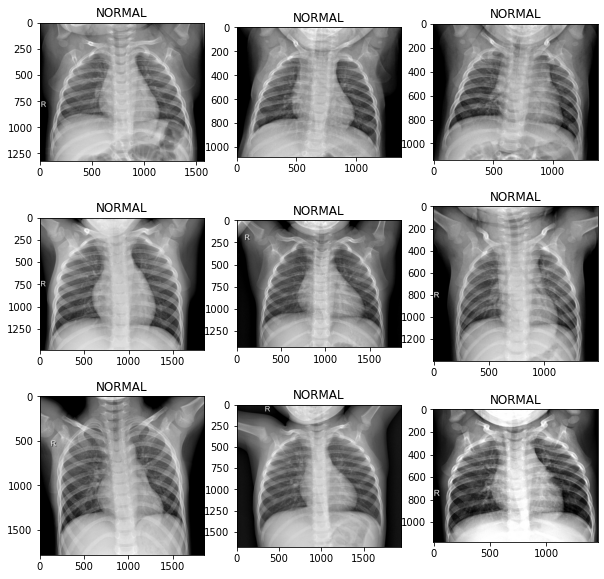

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()

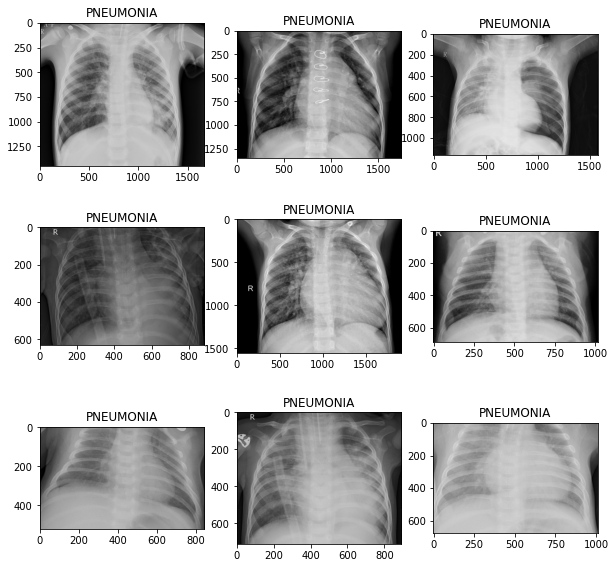

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/PNEUMONIA",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
plt.show()

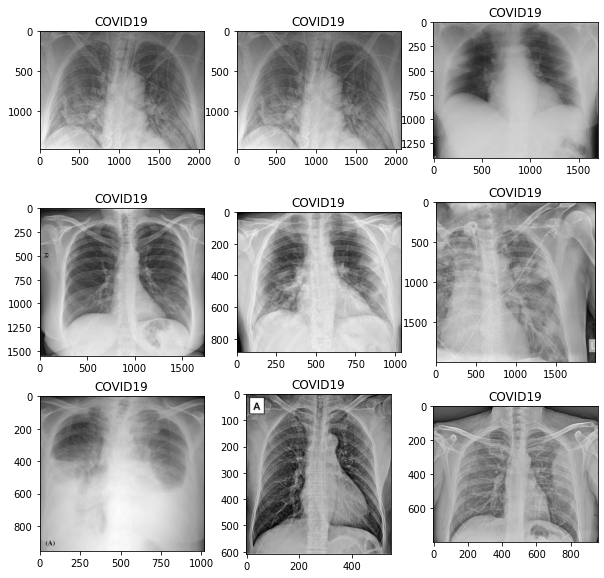

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")
plt.show()

#Prepocess data

In [ ]:
test_path = TestImage #set test path
train_path =  TrianImage #Set train path

##Data augmentation





*   Define data augmentation parametes
* Data normalization (image array with values 0 to 1 )
*   Create trainin and testing objects to feed the model



In [ ]:
image_size = 256 #Define image size
train_data_gen = ImageDataGenerator(rescale = 1./255, 
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True) #Define parameteres for data augmentation

test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
batch_size = 32 # Define batch size

training_set = train_data_gen.flow_from_directory(train_path,
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               class_mode='categorical') # Creat training object

Found 5177 images belonging to 3 classes.


In [ ]:
testing_set = train_data_gen.flow_from_directory(test_path,
                                               target_size=(image_size,image_size),
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=False) #Create testin object

Found 1290 images belonging to 3 classes.


In [ ]:
print(training_set.class_indices)
print(testing_set.class_indices)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [ ]:
print("train batch ", training_set.__getitem__(0)[0].shape) #Print shape of a batch in the training set
print("test batch ", testing_set.__getitem__(0)[0].shape) #Print shape of a batch in the testing set
print("sample train label \n", testing_set.__getitem__(0)[1][2:5])

train batch  (32, 256, 256, 3)
test batch  (32, 256, 256, 3)
sample train label 
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


#Residual Network(RESNET50)

##Identity block

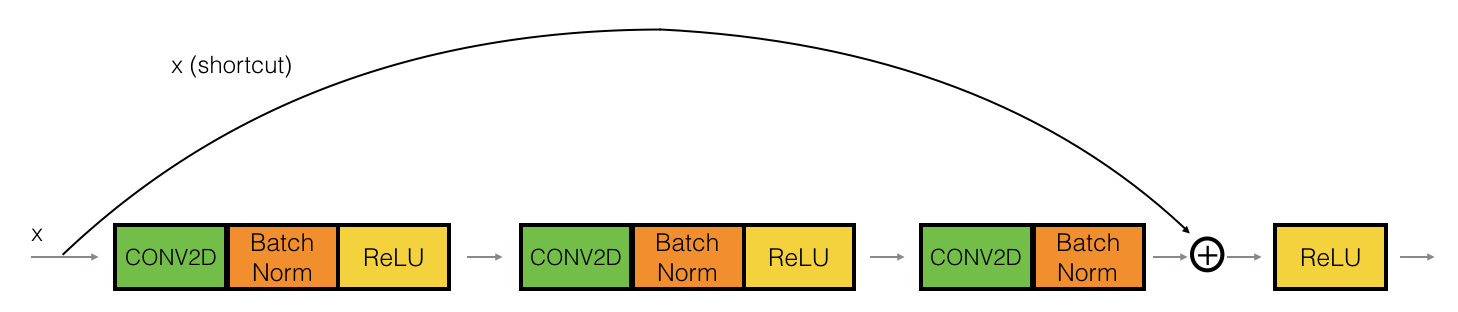


Identity block skip connection, skip over 3 layers

In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X =  Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

##Convolution block

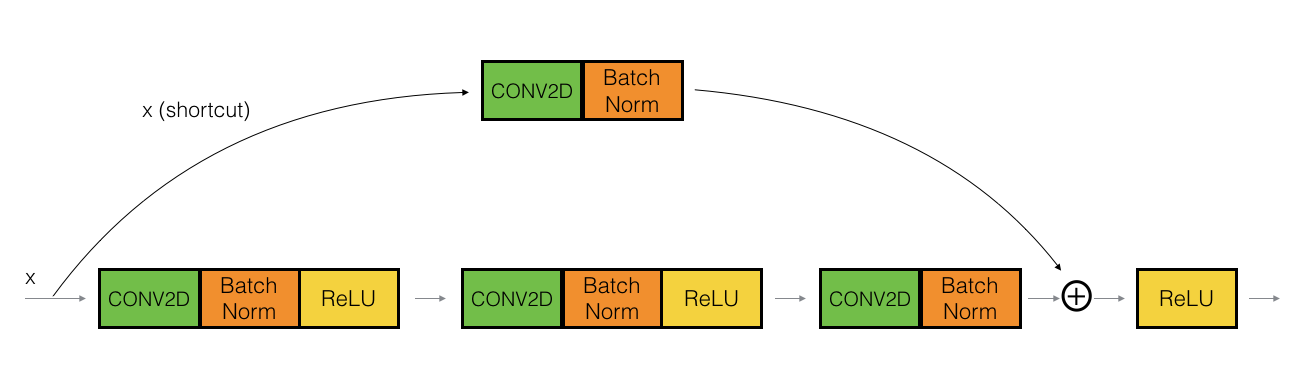

Convolution block

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    # Second component of main path
    X = Conv2D(filters=F2,kernel_size= (f, f), strides = (1,1),padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters=F3,kernel_size= (1, 1), strides = (1,1),padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides = (s,s),padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X)

    #Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

##RESNET50(Model)




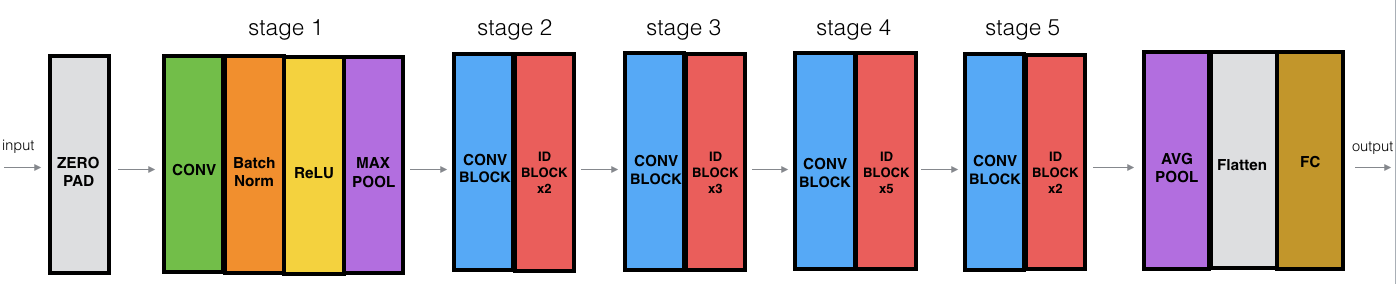

Residual network model with 50 layers within 5 stages

In [ ]:
def ResNet50(input_shape = ( image_size, image_size, 3), classes = 3):
    
    w = input_shape[0]
    h = input_shape[1]
    print(w,h)

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [w, h, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [w, h, 256], stage=2, block='b')
    X = identity_block(X, 3, [w, h, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters =  [w*2, h*2,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [w*2, h*2,512], stage=3, block='b')
    X = identity_block(X, 3, [w*2, h*2,512], stage=3, block='c')
    X = identity_block(X, 3, [w*2, h*2,512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [w*4, h*4, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3,  [w*4, h*4, 1024], stage=4, block='b')
    X = identity_block(X, 3,  [w*4, h*4, 1024], stage=4, block='c')
    X = identity_block(X, 3,  [w*4, h*4, 1024], stage=4, block='d')
    X = identity_block(X, 3,  [w*4, h*4, 1024], stage=4, block='e')
    X = identity_block(X, 3,  [w*4, h*4, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters =  [w*8, h*8, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3,  [w*8, h*8, 2048], stage=5, block='b')
    X = identity_block(X, 3,  [w*8, h*8, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D( pool_size=(2, 2))(X)


    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (image_size, image_size, 3), classes = 3)

256 256


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Train model

In [ ]:
stps_per_epoch =  num_of_training_images // batch_size # Calculate steps per epoch
epochs = 100 # Num.Of epochs that needed to train the model

hist = model.fit_generator(training_set,
                            steps_per_epoch=stps_per_epoch,
                            epochs=epochs) # Train the model using training object

Epoch 1/100
161/161 [==============================] - 2216s 14s/step - loss: 4.9477 - accuracy: 0.5841
Epoch 2/100
161/161 [==============================] - 260s 2s/step - loss: 1.4884 - accuracy: 0.7097
Epoch 3/100
161/161 [==============================] - 259s 2s/step - loss: 1.6432 - accuracy: 0.7395
Epoch 4/100
161/161 [==============================] - 258s 2s/step - loss: 0.6496 - accuracy: 0.8027
Epoch 5/100
161/161 [==============================] - 260s 2s/step - loss: 0.7158 - accuracy: 0.8479
Epoch 6/100
161/161 [==============================] - 260s 2s/step - loss: 0.4236 - accuracy: 0.8485
Epoch 7/100
161/161 [==============================] - 258s 2s/step - loss: 0.3388 - accuracy: 0.8760
Epoch 8/100
161/161 [==============================] - 259s 2s/step - loss: 0.3268 - accuracy: 0.8849
Epoch 9/100
161/161 [==============================] - 262s 2s/step - loss: 0.2650 - accuracy: 0.8997
Epoch 10/100
161/161 [==============================] - 260s 2s/step - loss: 0.2

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Train_acc","Validation_acc"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Train_loss","Validation Loss"])
plt.show()

# Save the model

In [ ]:

# Save model in JSON format
model_json = model.to_json()
with open("/content/drive/MyDrive/Projects/Data Management Project/Trained model and weights/ResNet_model_v2.json", "w") as json_file:
    json_file.write(model_json)
print("Saved JSON model to the drive")

# Save weights in the model in HDF5 format
model.save_weights("/content/drive/MyDrive/Projects/Data Management Project/Trained model and weights/ResNet_model_v2.hdf5")
print("Saved HDF5 weights to drive")

# Save model in h5 format
model.save("/content/drive/MyDrive/Projects/Data Management Project/Trained model and weights/ResNet_model_v2.h5")
print("Saved H5 model to drive")

Saved JSON model to disk
Saved HDF5 model to disk
Saved H5 model to disk


#Load pretrained model

In [ ]:
model = load_model('/content/drive/MyDrive/Projects/Data Management Project/Trained model and weights/ResNet_model_v2.h5') 

# Evaluate Model

In [ ]:
preds = model.evaluate(testing_set)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

41/41 [==============================] - 364s 9s/step - loss: 0.1218 - accuracy: 0.9558
Loss = 0.12179569154977798
Test Accuracy = 0.9558139443397522


# Check images

[[9.9895084e-01 1.0450097e-03 4.1598501e-06]]


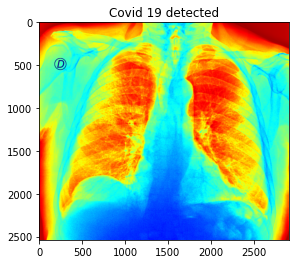

In [ ]:
from PIL import Image
from keras.preprocessing import image

image_path = "/content/drive/MyDrive/Projects/Data Management Project/Validate/COVID19(488).jpg"
img = image.load_img(image_path,target_size=(image_size,image_size)) 
img  = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img_norm = img/255

img_class=model.predict(img_norm) 
#print(img_class.shape)
print(img_class)

if img_class[0][0] > img_class[0][1] and img_class[0][0]>img_class[0][2]:
  output = "Covid 19 detected"
elif img_class[0][1] > img_class[0][0] and img_class[0][1] > img_class[0][2]:
  output = "You are normal"
else:
  output = "Pneumonia detected"


plt.imshow(plt.imread(image_path),cmap='gray')
plt.title(output)

import cv2
img1 = cv2.imread(image_path, 1)
heatmap_img = cv2.applyColorMap(img1, cv2.COLORMAP_JET)
plt.imshow(heatmap_img)
